# MILP(Mixed-Integer Linear Programming) Notebook

This notebook will walk you through the implementation of the baseline method using MILP(Mixed-Integer Linear Programming).

<br/>


In [1]:
import copy
import itertools
import time

import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
from gurobipy import GRB
from scipy.spatial import distance

from src.http_server.json_handlers import *
from src.http_server.utils.tsp_solver import k_opt
from src.utils.construct_map import construct_map
from src.visualization.visualization_pipeline import run_visualization_pipeline, visualize_paths

## 0. Specify problem parameters

<br/>

Here, specify the problem parameters according to the below table.

<br/>

| Python Variable | LaTeX Variable                   | Parameter Description                                                          |
|:----------------|:---------------------------------|:-------------------------------------------------------------------------------|
| `k`             | $k$                              | Number of Robots                                                               |
| `n`             | $n$                              | Number of Discrete Nodes to Place Per Axis                                     |
| `ssd`           | $SSD$                            | Length of each side of the square                                              |
| `d`             | $D$                              | Length of distance between the outermost nodes of each axis                    |
| `rp`            | $r$                              | Redundancy Parameter (Each node must be visited at list `rp` different robots) |
| `L_min`         | $L_\text{min-required-capacity}$ | Minimum Required Fuel to Cover the Area                                        |
| `L`             | $L_\text{max-capacity}$          | Maximum Fuel Capacity of Each Robot (We usually set this as a factor of L_min) |

<br/>


$R_\text{surveillance}$ is calculated by the following equation.

<br/>

<p style="text-align: center;">$R_\text{surveillance} = \frac{SSD}{\sqrt{2} n}$</p>

<br/>

We can calculate $D$ with using $R_\text{surveillance}$ because the corners and edges of the whole arena need not be covered. Use the following equation to update $D$. This becomes the distance between the outermost nodes in each axis.

<br/>

<p style="text-align: center;">$D = SSD - \sqrt{2}R_\text{surveillance}$</p>

<br/>

`L_min` is given by $2\sqrt{2}D$  (equation 5 in the report).


In [2]:
# Chose number of robots
k = 8
# Chose the number of targets in an axis (NOT NUMBER OF TOTAL NODES)
n = 8  # 64 nodes in total
# Chose the length of distance of each side of the square arena
ssd = 3.
# Chose the length of distance between the outermost nodes of each axis
sr = ssd / (np.sqrt(2.) * n)
d = ssd - np.sqrt(2.) * sr
# Choose the redundancy parameter (have each target be visited by exactly that many robots)
rp = min(3, k)
# Fuel Capacity Parameters
max_fuel_cost_to_node = d * np.sqrt(2)  # d√2 is the max possible distance between our nodes (-d/2, -d/2) and (d/2, d/2)
L_min = max_fuel_cost_to_node * 2  # Minimum required capacity is equal to the cost of the tour that only travels between the depot and the farthest node
fcr = 1.5
L = L_min * fcr  # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + max_fuel_cost_to_node  # See MRPCP paper for this

milp_start_time = time.time()
job_id = f"mrpcp-standalone/{k}_{n}_{ssd}_{fcr}_{rp}_m"

metadata = {"mode": "m", "v": 0.2, "t": 300., "dt": 0.1, "lookback_time": 30.,
            "visualize_paths_graph_path": saveGraphPath(job_id, "all_robot_paths.png"),
            "visitation_frequency_graph_path": saveGraphPath(job_id, "visitation_frequency.png"),
            "percent_coverage_visualization": saveGraphPath(job_id, "percent_coverage_visualization.png"),
            "node_visitation_heatmap": saveGraphPath(job_id, "node_visitation_heatmap.png"),
            "mean_time_between_revisitation": saveGraphPath(job_id, "mean_time_between_revisitation.png"),
            "milp_visualize_subfolder": saveGraphPath(job_id, "intermediate_solutions/"), "job_id": job_id,
            "saveResultsToCache": saveResultsToCache, "TimeLimit": 100, "num_threads_available": 10, "k": k, "n_a": n,
            "ssd": ssd, "ssd_discrete": d, "fcr": fcr, "rp": rp, "L_min": L}


## 1. Create map and get node indices

<br/>

The function `construct_map` creates a map with a total of 65 nodes, 64 targets (blue) and 1 depot (red). 


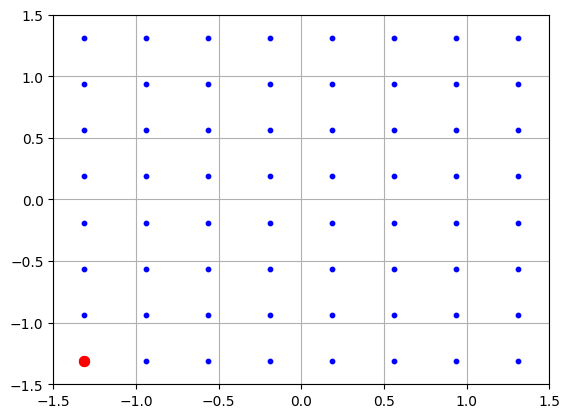

Constructing the map took 0.05817079544067383 seconds.


In [3]:
# 1. Create map and get node indices
start = time.time()
nodes, node_indices, target_indices, depot_indices = construct_map(n, ssd, d, milp=True, gfx_sanity_check=True)
B_k = np.array([depot_indices[0]] * k)
print(f"Constructing the map took {time.time() - start} seconds.")

## 2. Calculate cost between each node

<br/>

Create a 65x65 cost matrix to later provide $O(1)$ lookup for cost between nodes.


In [4]:
# 2. Calculate cost between each node
start = time.time()
cost = distance.cdist(nodes, nodes, 'euclidean')
print(f"Constructing the cost matrix took {time.time() - start} seconds.")

Constructing the cost matrix took 0.00014400482177734375 seconds.


## 3. Solve for given parameters
---

<br/>

Now that the setup is done, start solving the problem here. We first defined a MILP formulation, and solved it using Gurobi. This formulation is modified from the work of Mitchell et al. We used this solution as a baseline for developing and testing our heuristics. This section includes all the equations we used and modified for our MILP formulation.

<br/>

$T$ is the set of all targets, and $D$ is the set of all depots. In our case, we only have only one physical location for refueling, but we need two discrete depots to solve the problem. One depot is used to have the robots start and end ($D_{s}$), and the other is used for intermediate refuels ($D_{r}$). Since the two depots map to the same physical location (overlaid), in practice, it makes no difference which one is visited. $N$ is the union of the two sets ($N = T \cup D $). $K$ is the set of all robots.

<br/>

$\boldsymbol{C}$ is a two-dimensional cost matrix, where $\boldsymbol{C}_{ij}$ denotes the distance cost to travel from node $i$ to $j$. $\boldsymbol{X}$ is a binary three-dimensional edges matrix, where $\boldsymbol{X}^{k}_{ij} = 1$ if there is a connection from node $i$ to $j$ for robot $k$, and $\boldsymbol{X}^{k}_{ij} = 0$ otherwise. $\boldsymbol{P}$ is an intermediate matrix used to enforce the capacity and flow constraints, where $\boldsymbol{P}^{k}_{ij}$ indicates the remaining number of targets to visit for robot $k$ as it travels from node $i$ to $j$. Lastly, $\boldsymbol{R}$ is the fuel matrix used to enforce fuel constraints, where $\boldsymbol{R}^{k}_{ij}$ is the fuel left (in distance units) for the robot $k$ as it travels from node $i$ to $j$.

<br/>

MILP consists of four set of constraints.

<br/>

### 3.1 A. Integer Constraints

<br/>

This constraint makes sure that an edge can either exist or not. It is not possible to have more than one edge between two nodes.

<br/>

<p style="text-align: center;">$\boldsymbol{X}_{i j}^k \in\{0,1\} \quad \forall i, j \in N, k \in K$</p>


In [5]:
m = gp.Model()

# Note: All equation numbers are from the MRPCP paper
# A. Integer Constraints (4), (5)
start = time.time()
x = m.addMVar((k, len(node_indices), len(node_indices)), name='x', vtype=GRB.BINARY)
print(f"Setting up (A.) integer constraints took {time.time() - start} seconds.")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2419685
Academic license 2419685 - for non-commercial use only - registered to lu___@icloud.com
Setting up (A.) integer constraints took 0.06042003631591797 seconds.


### 3.2 B. Degree Constraints

<br/>

These constraints make sure that robots start and end at the depot, and each target is visited $r$ times. Equations (1) and (2) ensure that there is exactly $r$ incoming and outgoing edges for each target. Equations (3) and (4) ensure that, when there is a need for redundancy ($r > 1$), a robot has at most 1 connection going into and coming out of a target to avoid having two incoming/outgoing edges to/from the same node, which would break the flow. Equations (5) and (6) ensure that, if a robot is going to be used in the solution, it starts and ends at a specific depot. Keeping the start/end depots and refueling depots separate allows MILP to keep track of paths (it always starts and ends at $D_s$). Equations (5) and (6) also show that it is possible to use less than the specified number of robots in the solution. Equation (7) ensures that, if a target has an incoming edge, it needs to have an outgoing edge too. Finally, Equation (8) ensures that there are no loopholes (i.e., a target cannot be connected to itself).

<br/>

<p style="text-align: center;">$\sum_{k \in K} \sum_{j \in N} \boldsymbol{X}_{ij}^k = r   \forall i \in T$</p>
<p style="text-align: center;">$\sum_{k \in K} \sum_{j \in N} \boldsymbol{X}_{ji}^k  = r  \forall i \in T$</p>
<p style="text-align: center;">$\sum_{j \in N} \boldsymbol{X}_{ij}^k \leq 1 \forall i \in T, \quad \forall k \in K, \quad \text{if} \hspace{0.05in} r > 1$</p>
<p style="text-align: center;">$\sum_{j \in N} \boldsymbol{X}_{ji}^k \leq 1 \forall i \in T, \quad \forall k \in K, \quad \text{if} \hspace{0.05in} r > 1$</p>
<p style="text-align: center;">$\sum_{j \in N} \boldsymbol{X}_{D_{s} j}^k \leq 1 \forall k \in K$</p>
<p style="text-align: center;">$\sum_{j \in N} \boldsymbol{X}_{j D_{s}}^k \leq 1  \forall k \in K$</p>
<p style="text-align: center;">$\sum_{i \in N}\left(\boldsymbol{X}_{i j}^k-\boldsymbol{X}_{j i}^k\right) = 0  \forall j \in N, \forall k \in K$</p>
<p style="text-align: center;">$\sum_{i \in N}\boldsymbol{X}_{i i}^k = 0 \forall i \in N, \forall k \in K$</p>



In [6]:
# B. Degree Constraints (6), (7), (8), (9), (10)
start = time.time()
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:, i, :].sum() == rp for i in target_indices)
_ = m.addConstrs(x[:, :, i].sum() == rp for i in target_indices)

for ki in range(k):
    if rp > 1:
        _ = m.addConstrs(x[ki, i, :].sum() <= 1 for i in target_indices)
        _ = m.addConstrs(x[ki, :, i].sum() <= 1 for i in target_indices)

    # (8) and (9) Begin and end at same position B_k
    # _ = m.addConstr(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() >= 1)
    _ = m.addConstr(x[ki, B_k[ki], :].sum() <= 1)
    # _ = m.addConstr(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() >= 1)
    _ = m.addConstr(x[ki, :, B_k[ki]].sum() <= 1)

    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki, :, i] - x[ki, i, :]).sum() == 0 for i in node_indices)

    # Additional constraint: no loopholes!
    _ = m.addConstrs(x[ki, i, i] == 0 for i in node_indices)
print(f"Setting up (B.) degree constraints took {time.time() - start} seconds.")

Setting up (B.) degree constraints took 0.33722424507141113 seconds.


### 3.3 C. Capacity and Flow Constraints

<br/>

These constraints ensure that the paths assigned to robots consist of subtours, that are single enclosed loops. $\boldsymbol{P}_{i j}^k$ represents the number of remaining nodes to visit. Equation (1) sets the number of nodes to visit, to the number of edges in a robot’s subtour. More specifically, it ensures that the difference in “units held” between the start and end node equals to the number of edges in a robot’s path. Equation (2) reduces “units held” by one each time a new target is visited. This mimics the dropping off of that “unit” to that target. Equation (3) ensures that depot refueling trips do not count towards the capacity constraints. Lastly, equation (4) ensures that a robot cannot hold less than 0 units, and cannot hold more units than the number of targets in the field.

<br/>

<p style="text-align: center;">$\sum_{i \in N}\left(\boldsymbol{P}_{D_{s} i}^k-\boldsymbol{P}_{i D_{s}}^k\right) = \sum_{i \in T, j \in N} \boldsymbol{X}_{i j}^k \forall k \in K$</p>
<p style="text-align: center;">$\sum_{j \in N}\left(\boldsymbol{P}_{j i}^k-\boldsymbol{P}_{i j}^k\right) = \sum_{j \in N} \boldsymbol{X}_{i j}^k \forall i \in T, \quad \forall k \in K$</p>
<p style="text-align: center;">$\sum_{j \in N} \boldsymbol{P}_{j D_{r}}^k - \boldsymbol{P}_{D_{r} j}^k = 0 \forall k \in K$</p>
<p style="text-align: center;">$0 \leq \boldsymbol{P}_{i j}^k \leq |T| \boldsymbol{X}_{i j}^k \forall i, j \in N, k \in K$</p>


In [7]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
start = time.time()
p = m.addMVar((k, len(node_indices), len(node_indices)), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    right_side = 0
    for i, j in itertools.product(target_indices, node_indices):
        right_side += x[ki, i, j]
    _ = m.addConstr((p[ki, B_k[ki], :] - p[ki, :, B_k[ki]]).sum() == right_side)

    for i in target_indices:
        _ = m.addConstr((p[ki, :, i] - p[ki, i, :]).sum() == x[ki, i, :].sum())

    # (13) Make sure target capacity doesn't change when passing through a depot
    # Note: Disable for now because we only have one depot which is the starting point
    for i in depot_indices:
        if i == B_k[ki]: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
        left_side = 0
        for j in node_indices:
            if i == j: continue
            left_side += p[ki, j, i] - p[ki, i, j]
        _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki, i, j] <= len(target_indices) * x[ki, i, j] for i in node_indices for j in node_indices)
print(f"Setting up (C.) capacity and flow constraints took {time.time() - start} seconds.")

Setting up (C.) capacity and flow constraints took 13.174216985702515 seconds.


### 3.4 D. Fuel Constraints

<br/>

These constraints ensure that the paths generated satisfy all the fuel constraints (i.e., a robot is always scheduled to refuel at the depot before it is out of fuel). First, we set $M$ to the sum of fuel capacity and the maximum distance between the depot and targets. The maximum distance between the depot and targets is, then half of $L_\text{min-required-capacity}$. Equations (2) and (3) ensure that, the fuel lost between nodes $i$ and $j$ equal to the cost of going from node $i$ to $j$. Equations (4) and (5) ensure that, the fuel capacity after leaving a depot on its way to target $i$ equals the fuel capacity minus the cost to travel from the depot to target $i$. Equation (6) ensures that a robot always has enough fuel to go to the depot. Lastly, Equation (7) ensures that a robot fuel cannot exceed the fuel capacity at any time.

<br/>

<p style="text-align: center;">$M = L + \frac{L_\text{min-required-capacity}}{2}$</p>
<p style="text-align: center;">$\boldsymbol{R}^{k}_{ji}-\boldsymbol{R}^{k}_{ij}+\boldsymbol{C}_{i j} \leq M\left(1-\boldsymbol{X}_{i j}^k\right) \forall i, j \in T, k \in K$</p>
<p style="text-align: center;">$\boldsymbol{R}^{k}_{ji}-\boldsymbol{R}^{k}_{ij}+\boldsymbol{C}_{i j} \geq -M\left(1-\boldsymbol{X}_{i j}^k\right) \forall i, j \in T, k \in K$</p>
<p style="text-align: center;">$\boldsymbol{R}^{k}_{ji}-L+\boldsymbol{C}_{i j} \geq -M\left(1-\boldsymbol{X}_{i j}^k\right) \forall i \in D, \quad \forall j \in T, k \in K$</p>
<p style="text-align: center;">$\boldsymbol{R}^{k}_{ji}-L+\boldsymbol{C}_{i j} \leq M\left(1-\boldsymbol{X}_{i j}^k\right) \forall i \in D, \quad \forall j \in T, k \in K$</p>
<p style="text-align: center;">$\boldsymbol{R}^{k}_{ji}-\boldsymbol{C}_{j i} \geq -M\left(1-\boldsymbol{X}_{j i}^k\right) \forall i \in D, \quad \forall j \in T, k \in K$</p>
<p style="text-align: center;">$0 \leq \boldsymbol{R}^{k}_{ij} \leq L \forall i, j \in N, k \in K$</p>


In [8]:
# D. Fuel Constraints (15), (16), (17), (18), (19), (20)
start = time.time()
r = m.addMVar((k, len(node_indices), len(node_indices)), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L)  # (20)

for ki in range(k):
    # (15) and (16)
    for i, j in itertools.product(target_indices, target_indices):
        left_side = r[ki, j, i] - r[ki, i, j] + cost[i, j]
        right_side = M * (1 - x[ki, i, j])
        _ = m.addConstr(left_side <= right_side)
        _ = m.addConstr(left_side >= -right_side)

    # (17) and (18)
    for i, j in itertools.product(depot_indices, target_indices):
        left_side = r[ki, j, i] - L + cost[i, j]
        right_side = M * (1 - x[ki, i, j])
        _ = m.addConstr(left_side >= -right_side)
        _ = m.addConstr(left_side <= right_side)

        # (19)
        _ = m.addConstr(r[ki, j, i] - cost[j, i] >= -M * (1 - x[ki, j, i]))
print(f"Setting up (D.) fuel constraints took {time.time() - start} seconds.")

Setting up (D.) fuel constraints took 22.906824827194214 seconds.


### 3.5 Setting the objective function

<br/>

The objective function of the MILP formulation is as follows. $P_{\max }$ is a scalar variable and is equal to the cost of the most expensive path assigned to any robot.

<br/>

<p style="text-align: center;">$J^*=\min P_{\max }$</p>
<p style="text-align: center;">$\sum_{i \in N} \sum_{j \in N}\boldsymbol{C}_{i j} \boldsymbol{X}_{i j}^k \leq P_{\text {max }}  \quad \forall k \in K$</p>



In [9]:
# Set objective function (3)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

### 3.6 Solve the problem

<br/>

Finally start the solver. Make sure to save and visualize each (non-optimal) intermediate solution in case we want to use them later.

In [10]:
def convertEdgesToPaths(edges, nodes, depot_indices):
    edges = np.copy(edges)
    paths = []
    for ki in range(len(edges)):
        subtour_idx = 0
        list_of_subtours = [[]]
        curr_node = depot_indices[0]
        list_of_subtours[subtour_idx].append(curr_node)
        while True:
            if edges[ki][curr_node].sum() < 0.5:
                break
            next_node = np.argmax(edges[ki][curr_node])
            list_of_subtours[subtour_idx].append(int(depot_indices[0]) if next_node == depot_indices[1] else int(next_node))
            edges[ki][curr_node][next_node] = 0
            curr_node = next_node
            if curr_node == depot_indices[1]:
                subtour_idx += 1
                list_of_subtours.append([int(depot_indices[0])])

        filtered_list_of_subtours = []
        for i, si in enumerate(list_of_subtours):
            all_depot = True
            for ni in si:
                if not np.isclose(nodes[ni], nodes[depot_indices[0]]).all():
                    all_depot = False
            if not all_depot:
                filtered_list_of_subtours.append(si)
        if len(filtered_list_of_subtours):
            paths.append(filtered_list_of_subtours)
    return paths


class MILPSolver:
    min_cost_edges = None
    min_cost = np.inf
    selected_nodes = None
    opt_node_paths = None
    opt_world_paths = None
    start_time = None
    sol_counter = 0

    def __init__(self, model, num_threads=1):
        self.model = model
        MILPSolver.selected_nodes = []
        self.num_threads = num_threads
        MILPSolver.start_time = time.time()

    @staticmethod
    def cb(what, where):
        if where == GRB.Callback.MIPSOL and what.cbGet(GRB.Callback.MIPSOL_OBJ) < MILPSolver.min_cost:
            MILPSolver.min_cost = what.cbGet(GRB.Callback.MIPSOL_OBJ)
            print(f"Found a new solution with lower cost({MILPSolver.min_cost:.3f})!", flush=True)
            MILPSolver.min_cost_edges = what.cbGetSolution(what._x)

            # Convert edges to the node/world paths
            MILPSolver.opt_node_paths = convertEdgesToPaths(MILPSolver.min_cost_edges, nodes, depot_indices)
            MILPSolver.opt_world_paths = []
            for ki in range(len(MILPSolver.opt_node_paths)):
                robot_world_path = []
                for i, subtour in enumerate(MILPSolver.opt_node_paths[ki]):
                    robot_world_path.append(nodes[subtour].tolist())
                MILPSolver.opt_world_paths.append(robot_world_path)

            metadata["k"] = len(MILPSolver.opt_node_paths)

            # Save the milp found solution for visualization
            milp_node_paths = copy.deepcopy(MILPSolver.opt_node_paths)

            # Run TSP on the MILP discovered paths
            for kii in range(len(MILPSolver.opt_node_paths)):
                for sii in range(len(MILPSolver.opt_node_paths[kii])):
                    MILPSolver.opt_node_paths[kii][sii], _ = k_opt(MILPSolver.opt_node_paths[kii][sii], cost, 2)
                    # print(f"{kii=} {sii=} {MILPSolver.opt_node_paths[kii][sii]=}")

            # Generate the visualizations
            if "visualize_paths_graph_path" in metadata:
                metadata_new_sol = metadata.copy()
                metadata_new_sol["milp_visualize_subfolder"] = os.path.join(metadata_new_sol["milp_visualize_subfolder"], f"{MILPSolver.sol_counter}")
                os.makedirs(metadata_new_sol["milp_visualize_subfolder"], exist_ok=True)
                metadata_new_sol["visualize_paths_graph_path"] = os.path.join(metadata_new_sol["milp_visualize_subfolder"], metadata["visualize_paths_graph_path"].split("/")[-1])
                metadata_new_sol["visitation_frequency_graph_path"] = os.path.join(metadata_new_sol["milp_visualize_subfolder"], metadata["visitation_frequency_graph_path"].split("/")[-1])
                metadata_new_sol["percent_coverage_visualization"] = os.path.join(metadata_new_sol["milp_visualize_subfolder"], metadata["percent_coverage_visualization"].split("/")[-1])
                metadata_new_sol["node_visitation_heatmap"] = os.path.join(metadata_new_sol["milp_visualize_subfolder"], metadata["node_visitation_heatmap"].split("/")[-1])
                metadata_new_sol["mean_time_between_revisitation"] = os.path.join(metadata_new_sol["milp_visualize_subfolder"], metadata["mean_time_between_revisitation"].split("/")[-1])

                metadata_nnew_sol = metadata_new_sol.copy()
                metadata_nnew_sol["visualize_paths_graph_path"] = os.path.join(metadata_new_sol["milp_visualize_subfolder"], "milp.png")
                print("Visualizing MILP produced result")
                visualize_paths(milp_node_paths, metadata_nnew_sol)
                metadata_nnew_sol["visualize_paths_graph_path"] = os.path.join(metadata_new_sol["milp_visualize_subfolder"], "tsp.png")
                print("Visualizing post-processed result")
                visualize_paths(MILPSolver.opt_node_paths, metadata_nnew_sol)

                print("Running the visualization pipeline on the post-processed result")
                run_visualization_pipeline(MILPSolver.opt_node_paths, MILPSolver.opt_world_paths, metadata_new_sol)
                plt.close("all")

                # Save result in a JSON file within the cache folder
                result_data = {'job_id': metadata["job_id"],
                               'params': {'k': k, 'n_a': n, 'ssd': ssd, 'fcr': fcr, 'rp': rp, 'mode': 'm'},
                               'robot_node_path': MILPSolver.opt_node_paths, 'robot_world_path': MILPSolver.opt_world_paths,
                               'status': 'in-progress'}
                stats_data = {'job_id': metadata["job_id"], 'runtime': time.time() - MILPSolver.start_time,
                              'average_coverage': metadata_new_sol['average_coverage']}
                metadata["saveResultsToCache"](metadata["job_id"], result_data, os.path.join(metadata_new_sol["milp_visualize_subfolder"], f"result.json"))  # Save the results to the cache
                metadata["saveResultsToCache"](metadata["job_id"], stats_data, os.path.join(metadata_new_sol["milp_visualize_subfolder"], f"stats.json"))
                MILPSolver.sol_counter += 1

            # If this solution's maximum costing tour ~= the cost of tour that only travels between depot and the furthest node,
            # then, this is guaranteed to be optimal.
            if (MILPSolver.min_cost - L_min) < 0.01:
                print("!This is guaranteed to be the optimal solution!")
                what.terminate()
                # visualize_paths_brute_force(MILPSolver.min_cost_edges)

    def solve(self):
        self.model.optimize(MILPSolver.cb)

os.makedirs(metadata["milp_visualize_subfolder"], exist_ok=True)
m.setParam("LogFile", os.path.join(metadata["milp_visualize_subfolder"], "gurobi.log"))

if "TimeLimit" in metadata:
    m.setParam("TimeLimit", metadata["TimeLimit"])
    print(f"Set a time limit of {metadata['TimeLimit']} seconds")

if "num_threads_available" in metadata and metadata["num_threads_available"] > 0:
    num_threads_available = metadata["num_threads_available"]
else:
    num_threads_available = os.cpu_count() - 1  # Get the number of available CPU threads

# Print the number of available CPU threads
print(f"Number of available CPU threads: {num_threads_available}")

Set parameter LogFile to value "/Users/yasaridikut/WPI Classes/MQP Folder/milp-intro/src/mrpcp_2015/cache/mrpcp-standalone/8_8_3.0_1.5_3_m/graphs/intermediate_solutions/gurobi.log"
Set parameter TimeLimit to value 100
Set a time limit of 100 seconds
Number of available CPU threads: 10


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M3 Max
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2419685 - for non-commercial use only - registered to lu___@icloud.com
Optimize a model with 106216 rows, 104545 columns and 646296 nonzeros
Model fingerprint: 0x55dd0195
Variable types: 34849 continuous, 69696 integer (34848 binary)
Coefficient statistics:
  Matrix range     [4e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 54056 rows and 35384 columns
Presolve time: 0.79s
Presolved: 52160 rows, 69161 columns, 274744 nonzeros
Variable types: 1 continuous, 69160 integer (34840 binary)
Found a new solution with lower cost(166.287)!
Visualizing MILP produced result
	Visualizing paths for heuristic 1 or MILP...


3it [00:00, 15.89it/s]


Visualizing post-processed result
	Visualizing paths for heuristic 1 or MILP...


3it [00:00,  8.07it/s]


Running the visualization pipeline on the post-processed result
Running visualization pipeline...
	Visualizing paths for heuristic 1 or MILP...


3it [00:00,  9.32it/s]


	Visualizing visitation heatmap...
	Visualizing coverage over time...


100%|██████████| 3001/3001 [00:00<00:00, 19411.01it/s]

average_coverage=9.735759376504127


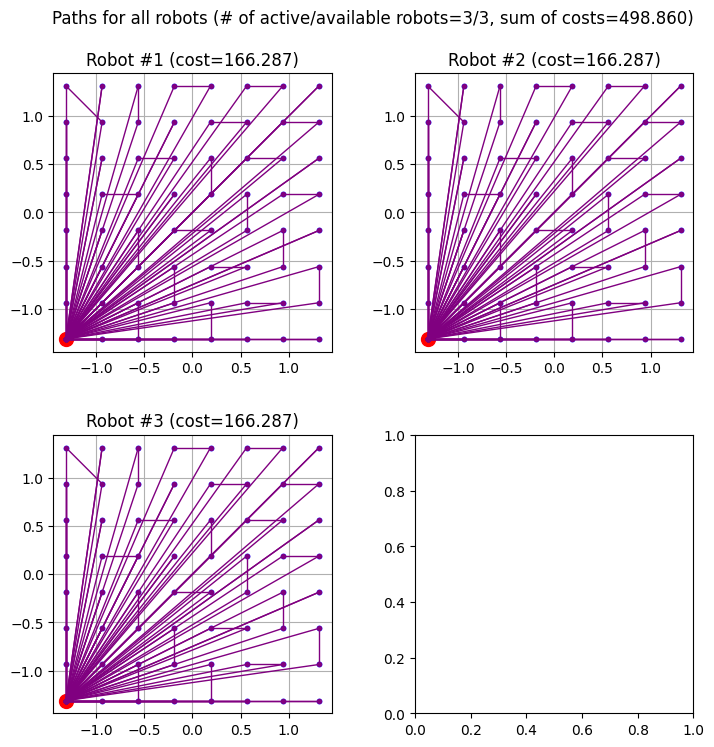

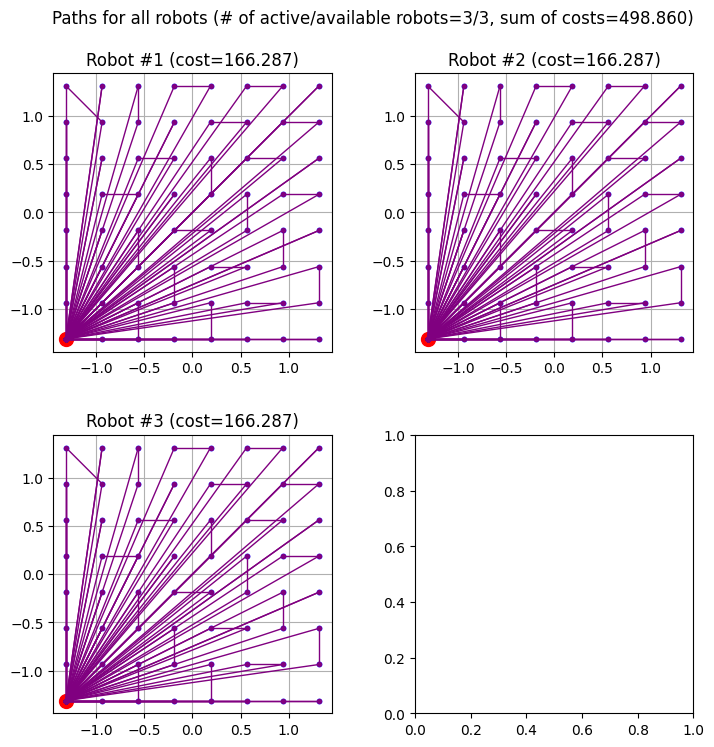

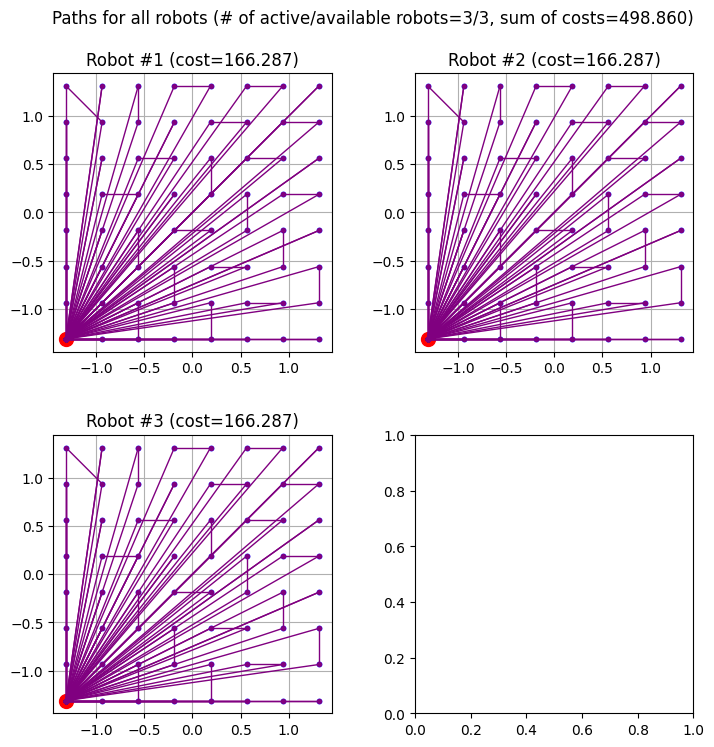

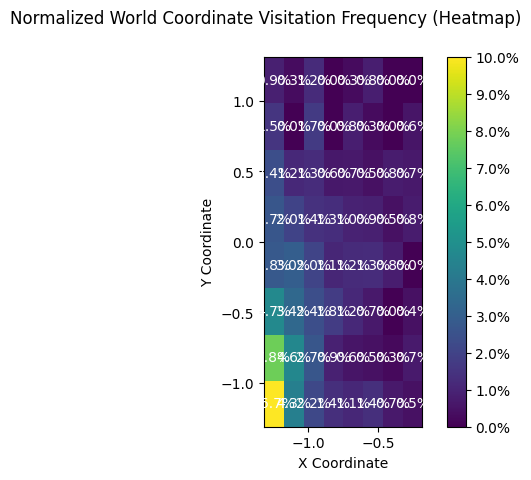

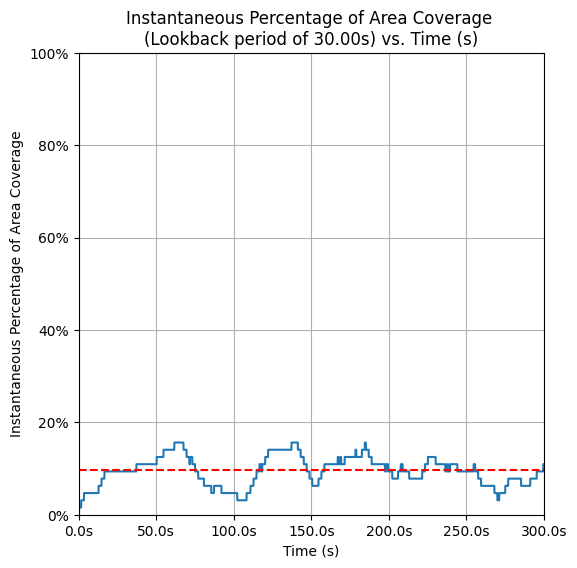

Visualizations complete! Returning metadata...
Result and parameters saved to  /Users/yasaridikut/WPI Classes/MQP Folder/milp-intro/src/mrpcp_2015/cache/mrpcp-standalone/8_8_3.0_1.5_3_m/graphs/intermediate_solutions/0/result.json
Result and parameters saved to  /Users/yasaridikut/WPI Classes/MQP Folder/milp-intro/src/mrpcp_2015/cache/mrpcp-standalone/8_8_3.0_1.5_3_m/graphs/intermediate_solutions/0/stats.json
Found heuristic solution: objective 166.2867523
Found a new solution with lower cost(90.992)!
Visualizing MILP produced result
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 63.17it/s]


Visualizing post-processed result
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 29.52it/s]


Running the visualization pipeline on the post-processed result
Running visualization pipeline...
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 48.40it/s]


	Visualizing visitation heatmap...
	Visualizing coverage over time...


100%|██████████| 3001/3001 [00:00<00:00, 6703.82it/s]


average_coverage=38.14816357510459


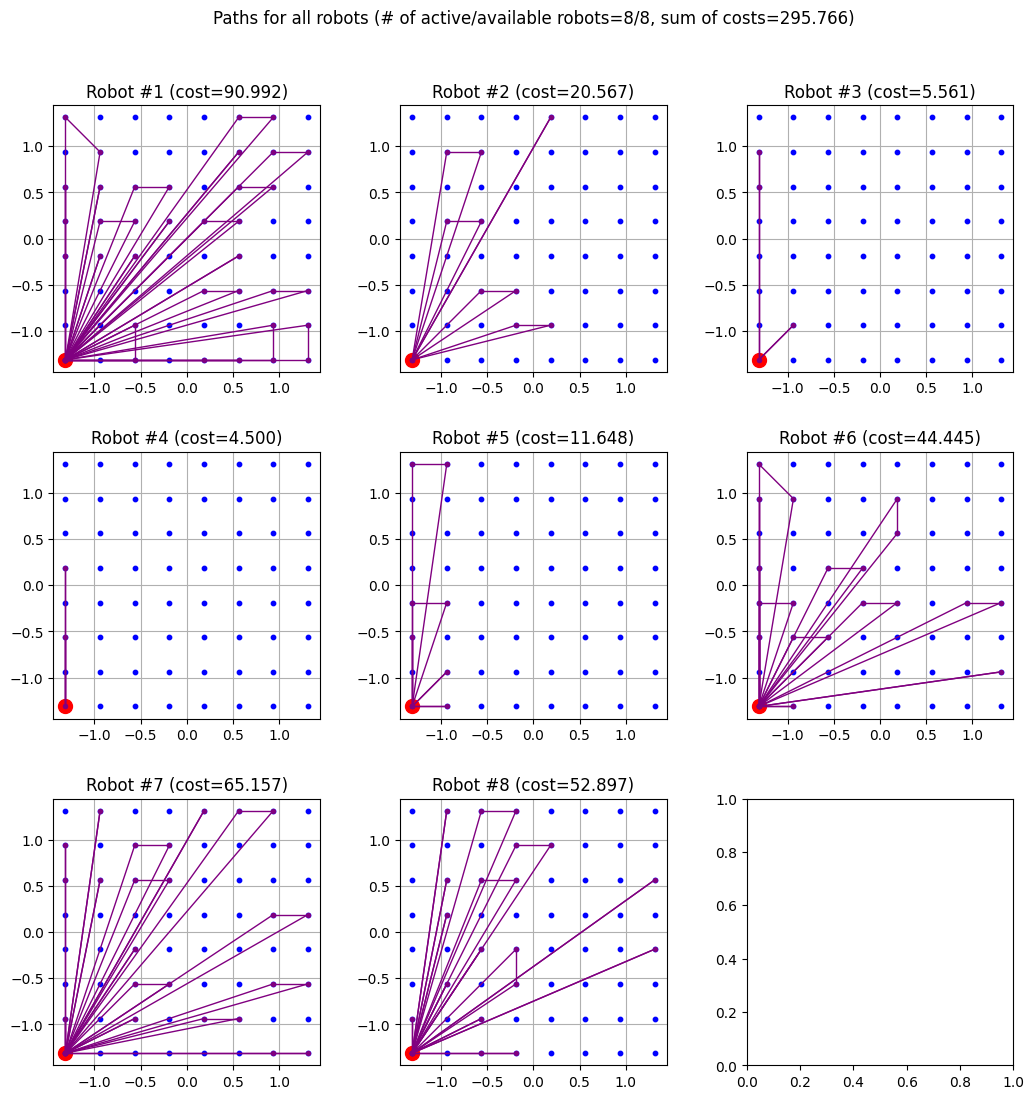

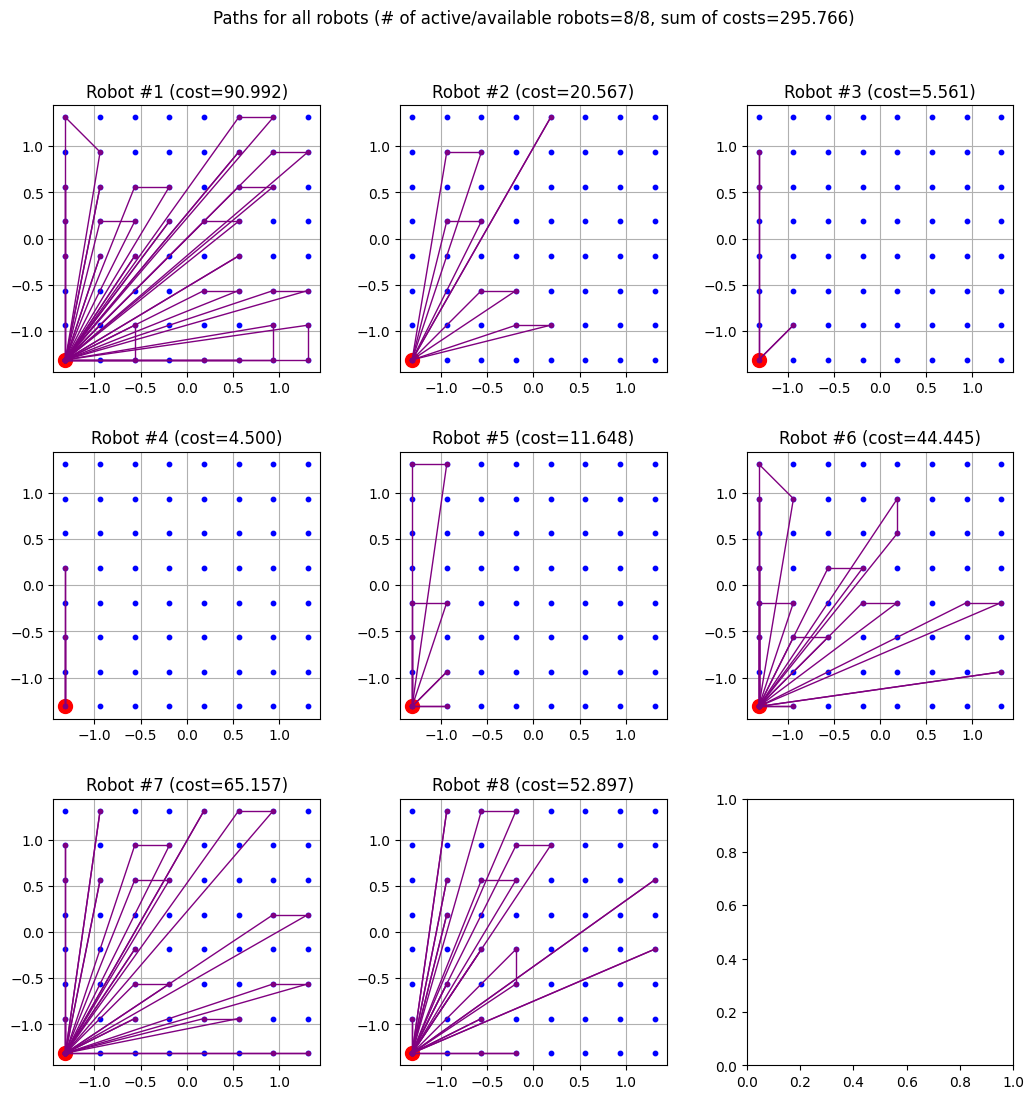

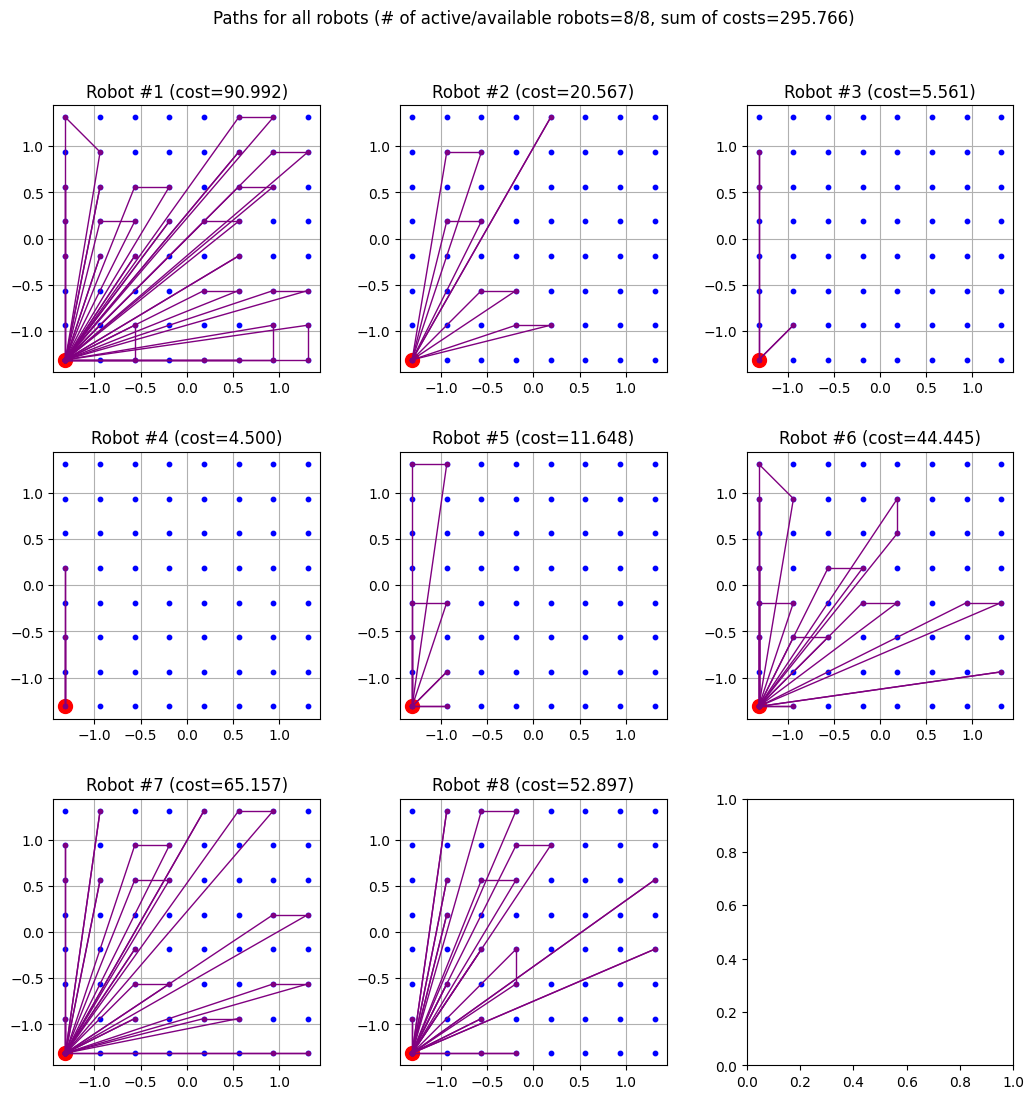

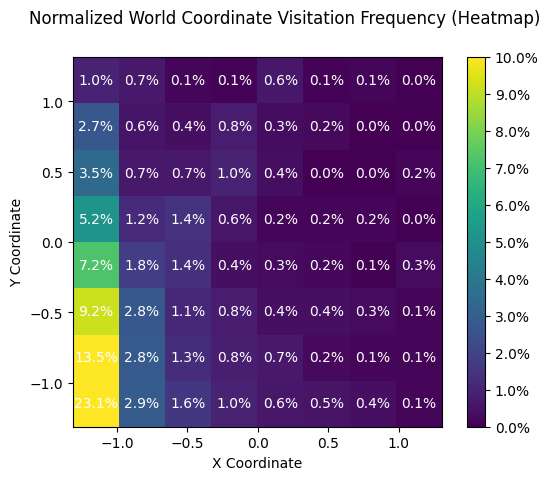

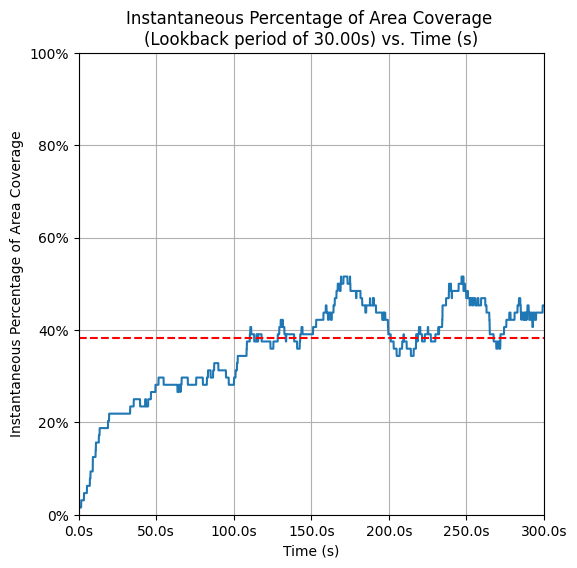

Visualizations complete! Returning metadata...
Result and parameters saved to  /Users/yasaridikut/WPI Classes/MQP Folder/milp-intro/src/mrpcp_2015/cache/mrpcp-standalone/8_8_3.0_1.5_3_m/graphs/intermediate_solutions/1/result.json
Result and parameters saved to  /Users/yasaridikut/WPI Classes/MQP Folder/milp-intro/src/mrpcp_2015/cache/mrpcp-standalone/8_8_3.0_1.5_3_m/graphs/intermediate_solutions/1/stats.json
Found heuristic solution: objective 90.9916088
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.8422881e+00   8.123000e+00   1.857000e+09     12s
    8529    8.9987129e+00   0.000000e+00   0.000000e+00     12s
Concurrent spin time: 0.00s

Solved with primal simplex
    8529    8.9987129e+00   0.000000e+00   0.000000e+00     12s

Use crossover to convert LP symmetric solution to basic solution...

Root crossover log...

       0 DPushes remaini

8it [00:00, 67.70it/s]


Visualizing post-processed result
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 39.49it/s]


Running the visualization pipeline on the post-processed result
Running visualization pipeline...
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 54.22it/s]


	Visualizing visitation heatmap...
	Visualizing coverage over time...


100%|██████████| 3001/3001 [00:00<00:00, 7234.24it/s] 


average_coverage=59.78042041541708


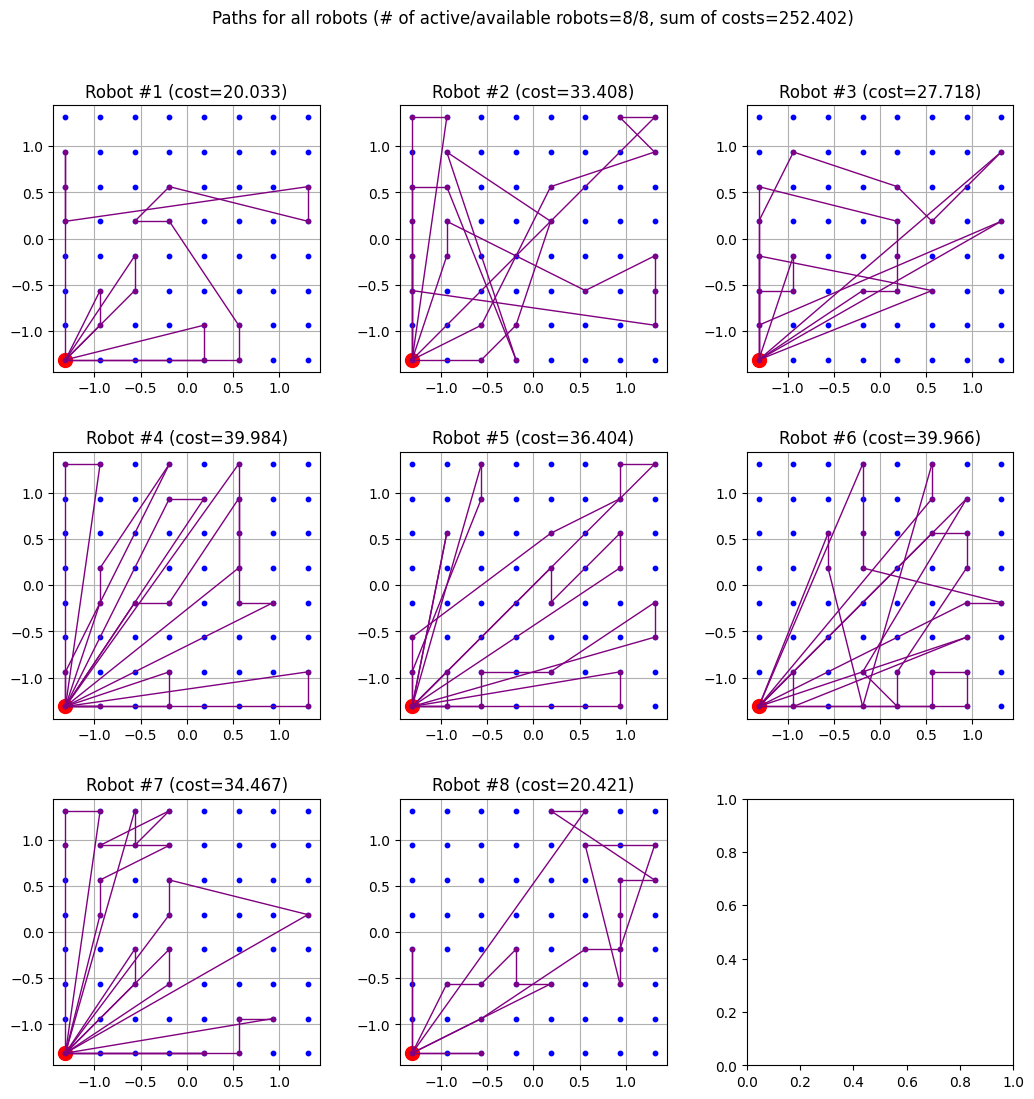

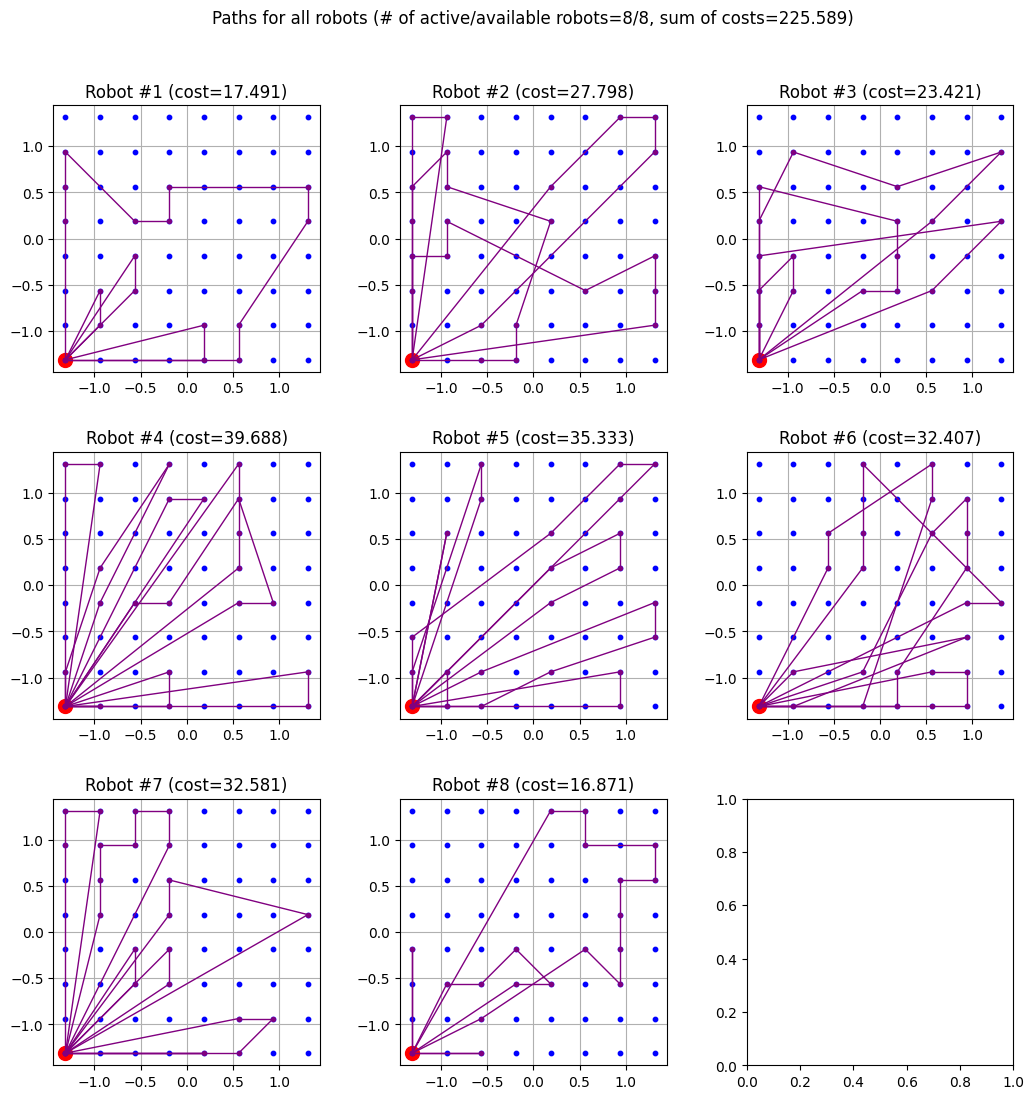

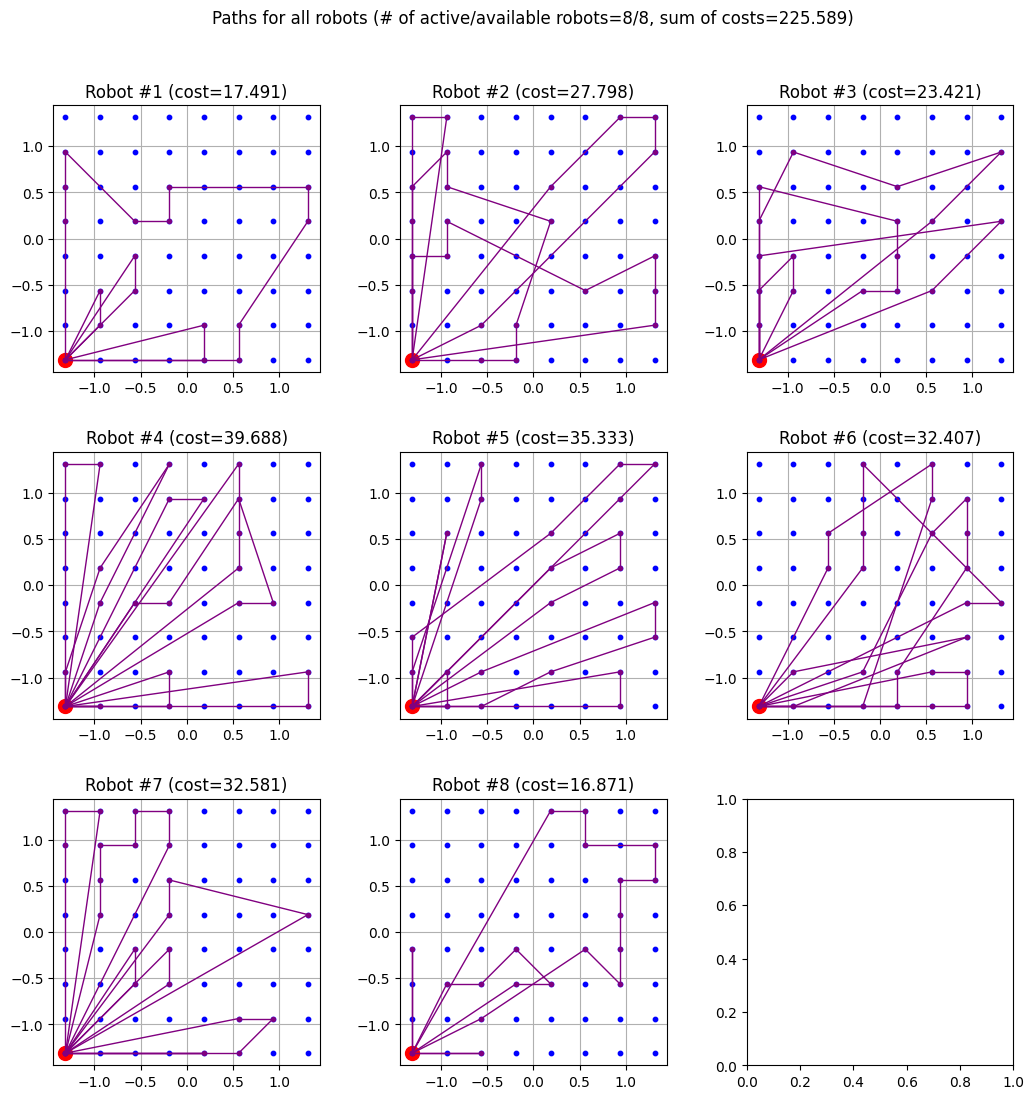

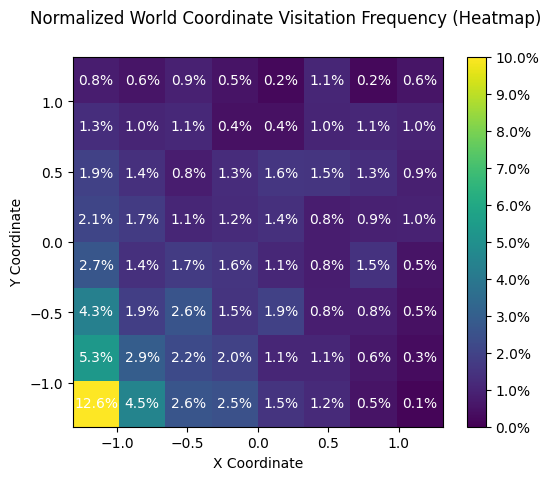

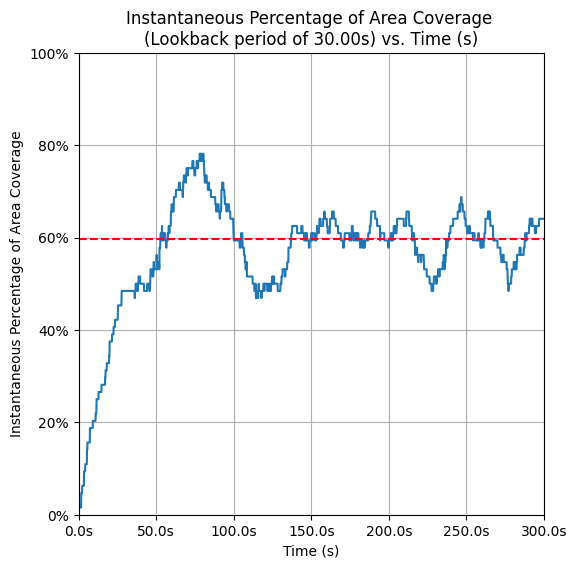

Visualizations complete! Returning metadata...
Result and parameters saved to  /Users/yasaridikut/WPI Classes/MQP Folder/milp-intro/src/mrpcp_2015/cache/mrpcp-standalone/8_8_3.0_1.5_3_m/graphs/intermediate_solutions/2/result.json
Result and parameters saved to  /Users/yasaridikut/WPI Classes/MQP Folder/milp-intro/src/mrpcp_2015/cache/mrpcp-standalone/8_8_3.0_1.5_3_m/graphs/intermediate_solutions/2/stats.json
H    0     0                      40.3245607    8.99871  77.7%     -   26s
Found a new solution with lower cost(39.543)!
Visualizing MILP produced result
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 72.25it/s]


Visualizing post-processed result
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 59.84it/s]


Running the visualization pipeline on the post-processed result
Running visualization pipeline...
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 59.65it/s]


	Visualizing visitation heatmap...
	Visualizing coverage over time...


100%|██████████| 3001/3001 [00:00<00:00, 7222.29it/s]


average_coverage=61.435540005183455


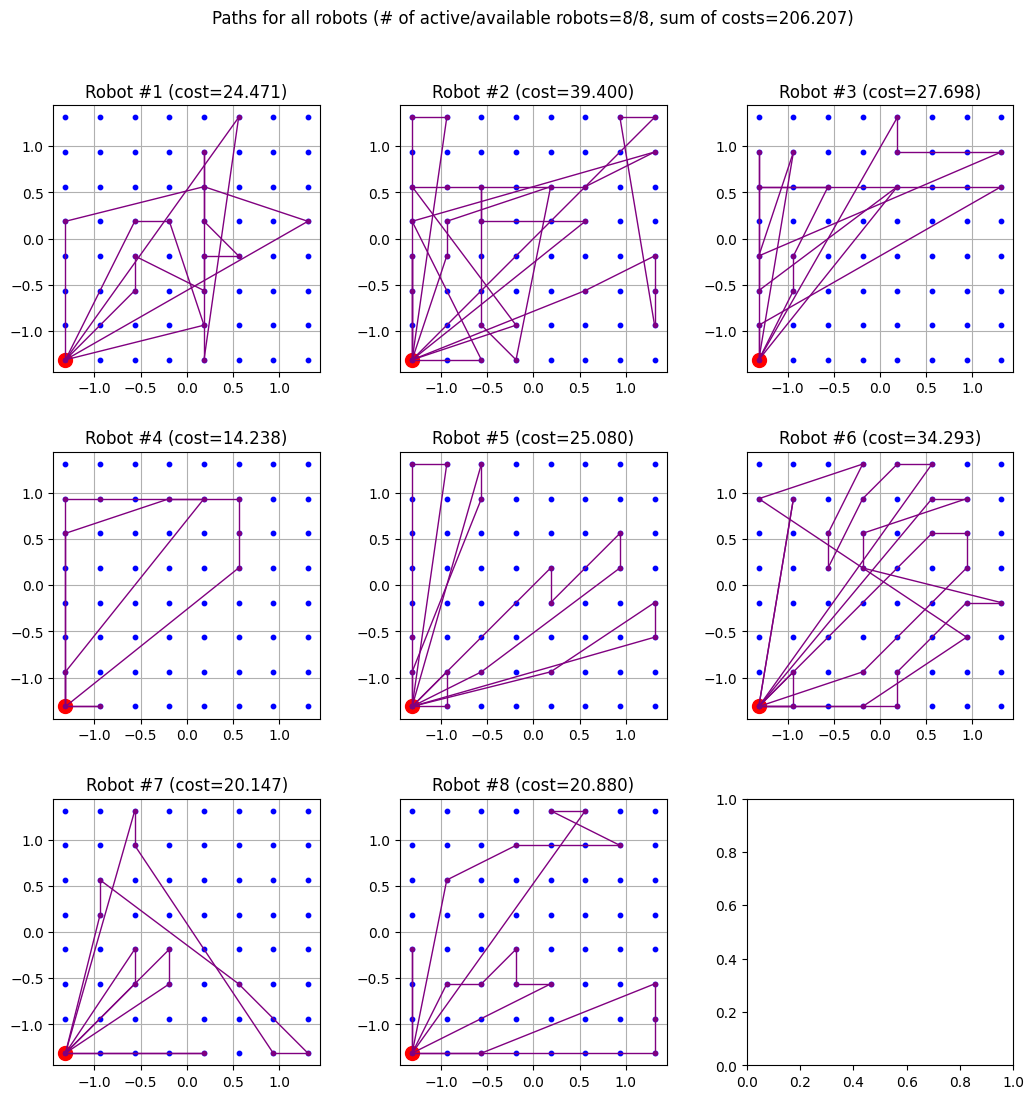

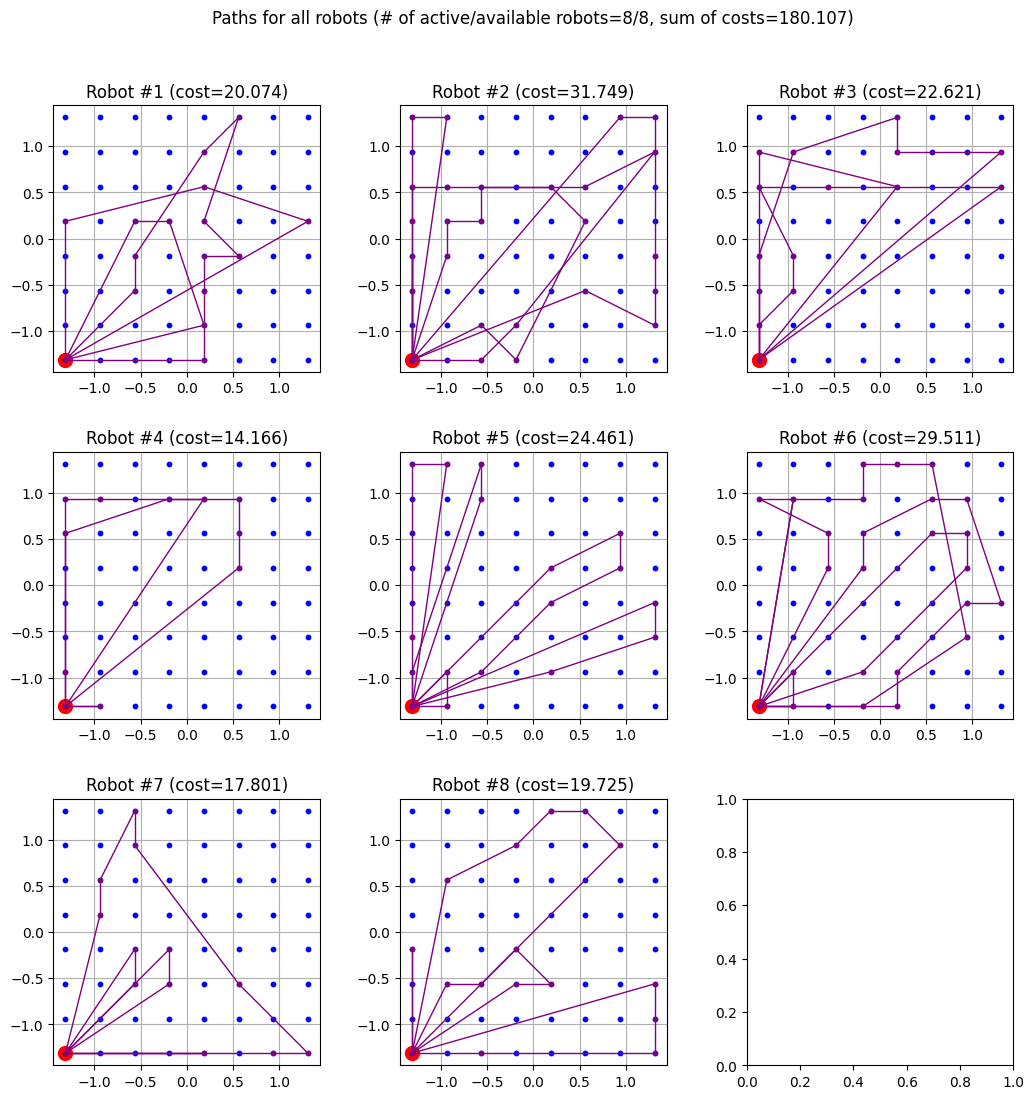

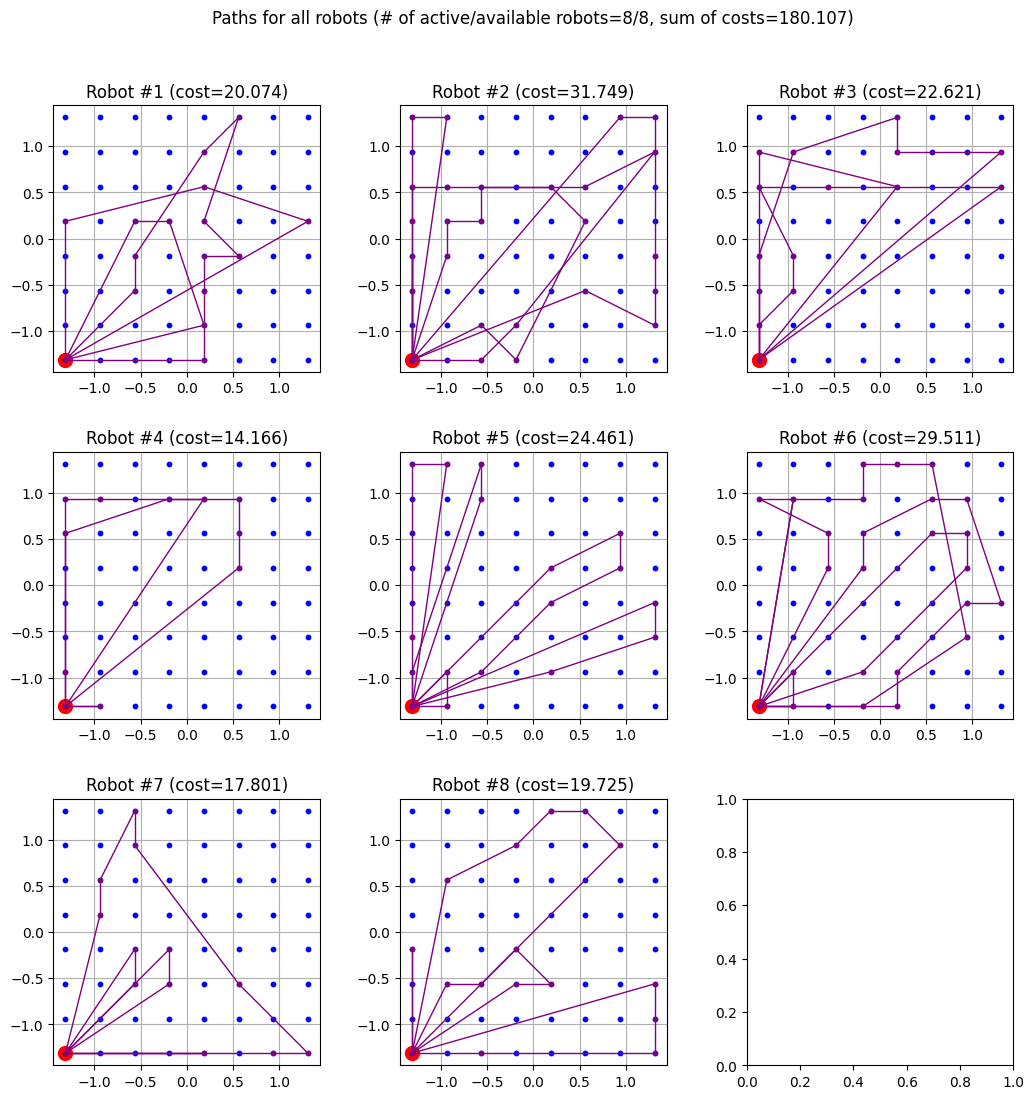

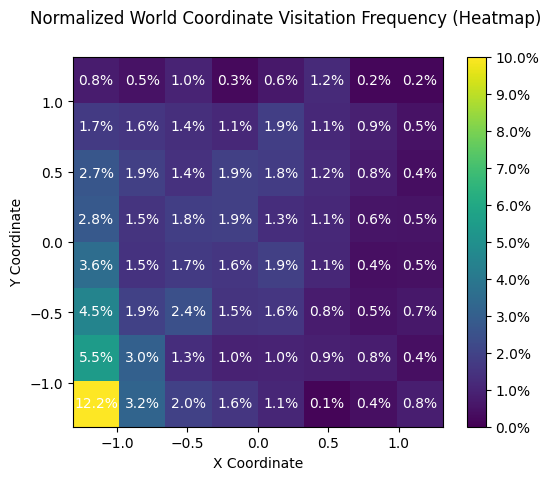

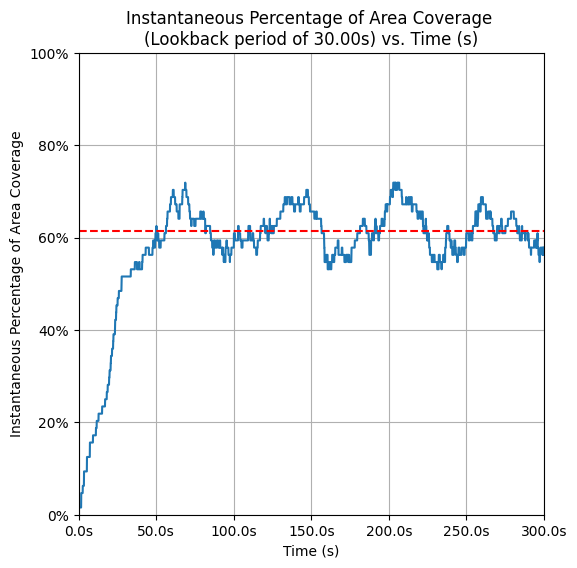

Visualizations complete! Returning metadata...
Result and parameters saved to  /Users/yasaridikut/WPI Classes/MQP Folder/milp-intro/src/mrpcp_2015/cache/mrpcp-standalone/8_8_3.0_1.5_3_m/graphs/intermediate_solutions/3/result.json
Result and parameters saved to  /Users/yasaridikut/WPI Classes/MQP Folder/milp-intro/src/mrpcp_2015/cache/mrpcp-standalone/8_8_3.0_1.5_3_m/graphs/intermediate_solutions/3/stats.json
H    0     0                      39.5427717    8.99871  77.2%     -   34s
Found a new solution with lower cost(24.003)!
Visualizing MILP produced result
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 34.83it/s]


Visualizing post-processed result
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 60.68it/s]


Running the visualization pipeline on the post-processed result
Running visualization pipeline...
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 37.08it/s]


	Visualizing visitation heatmap...
	Visualizing coverage over time...


100%|██████████| 3001/3001 [00:00<00:00, 6422.98it/s]


average_coverage=70.18783090821577


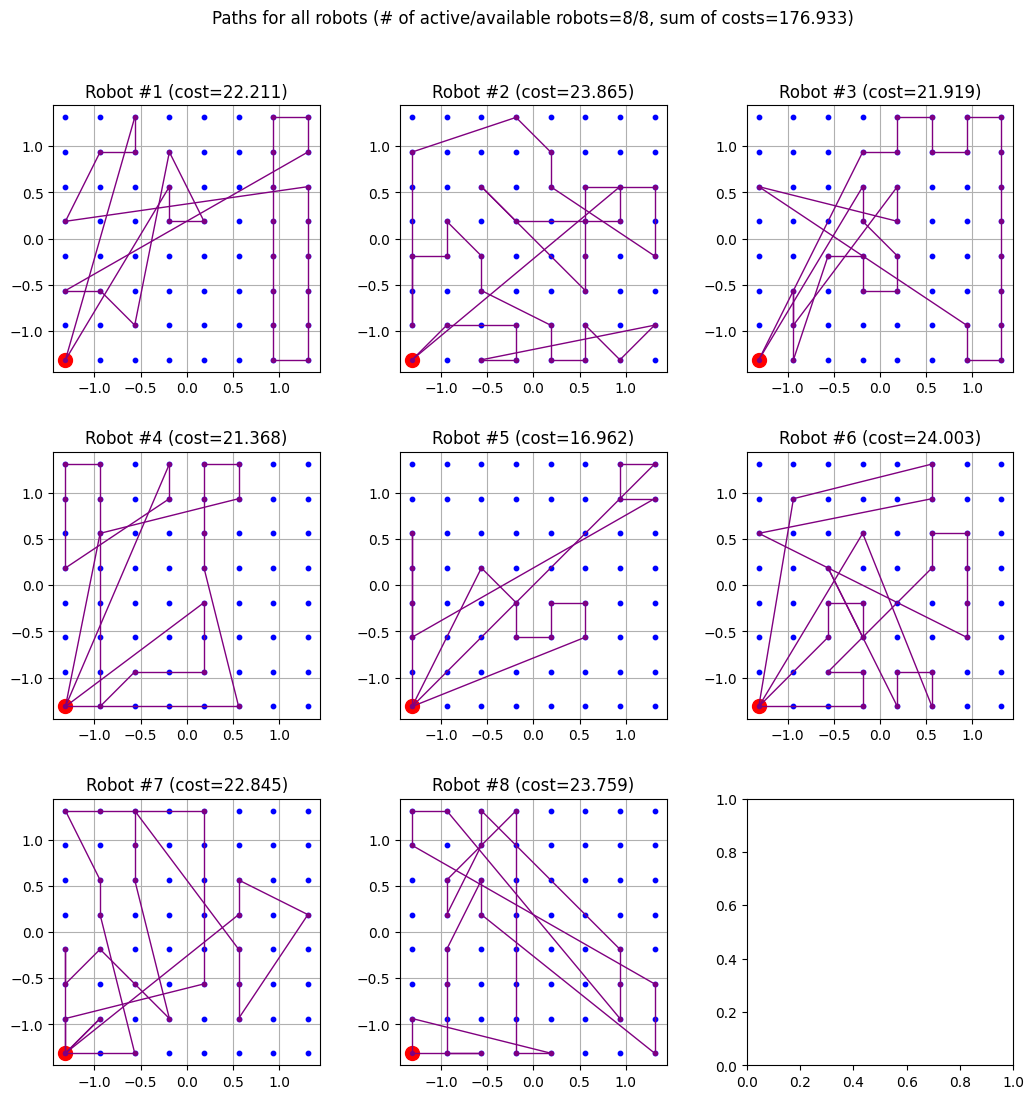

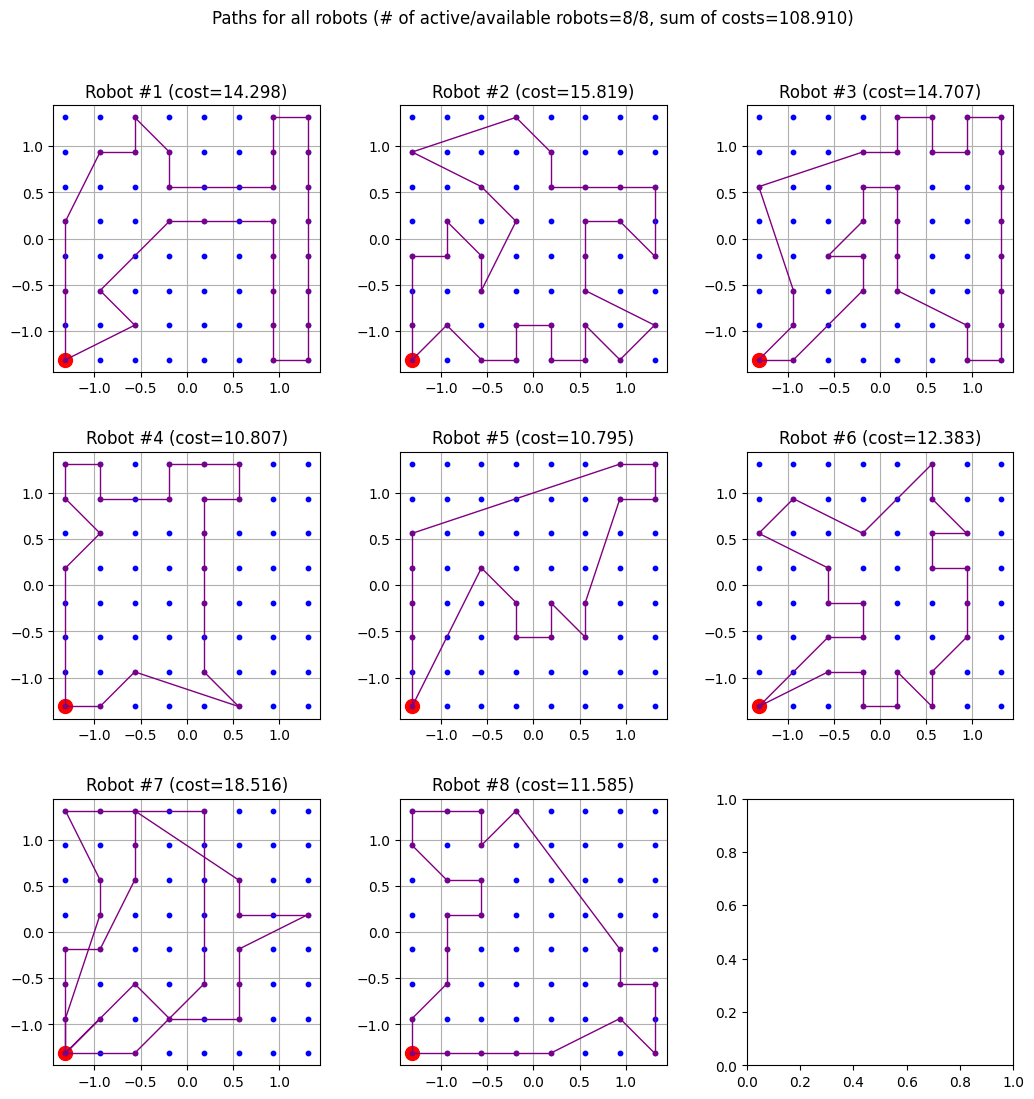

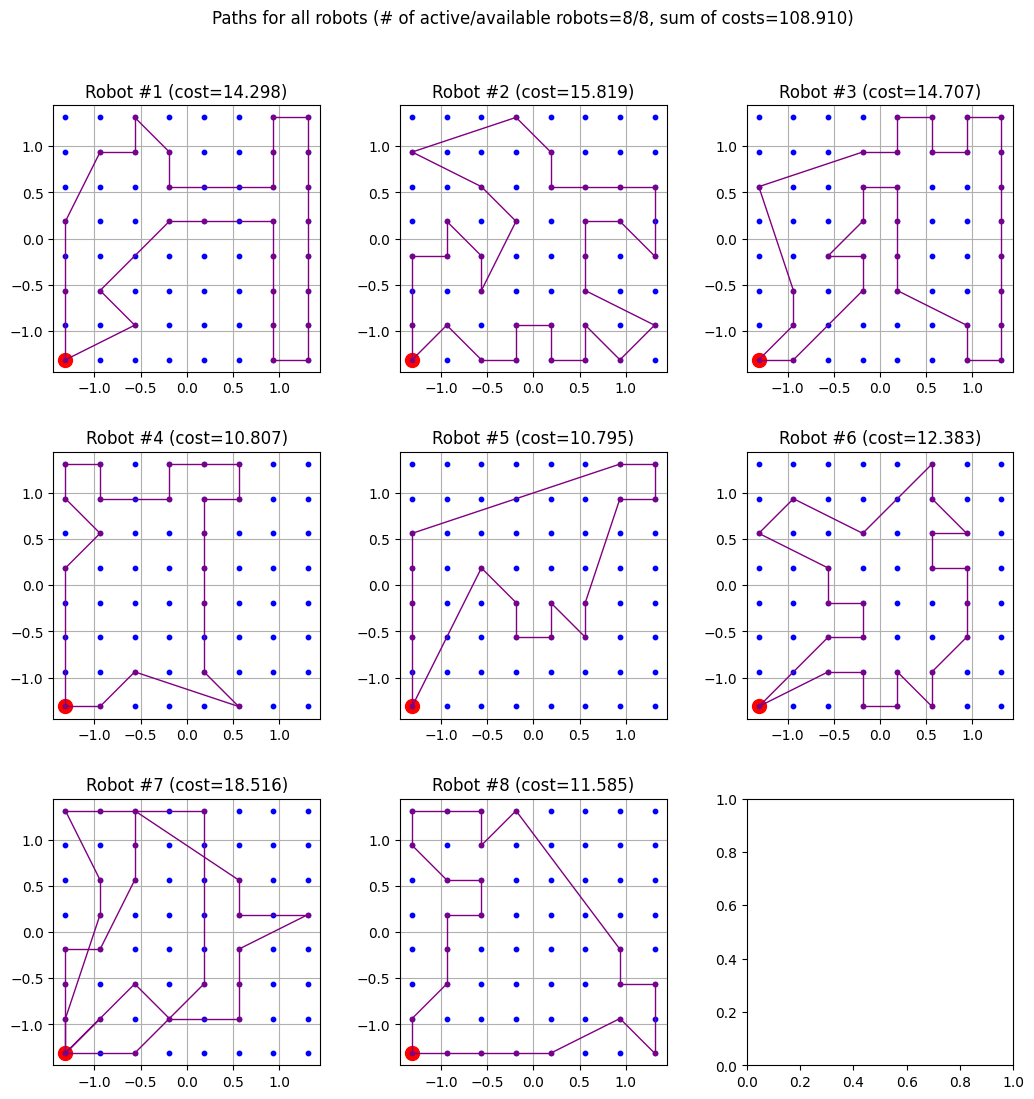

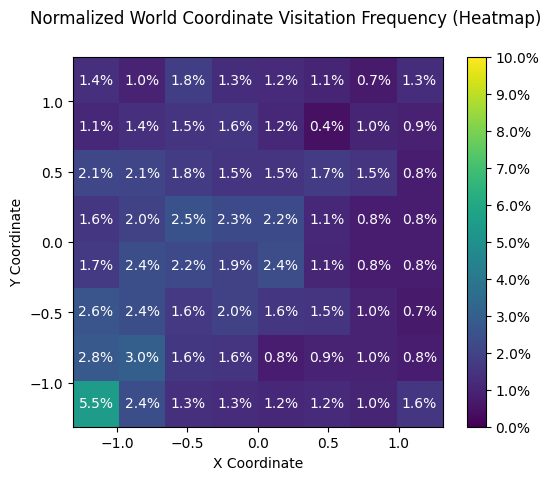

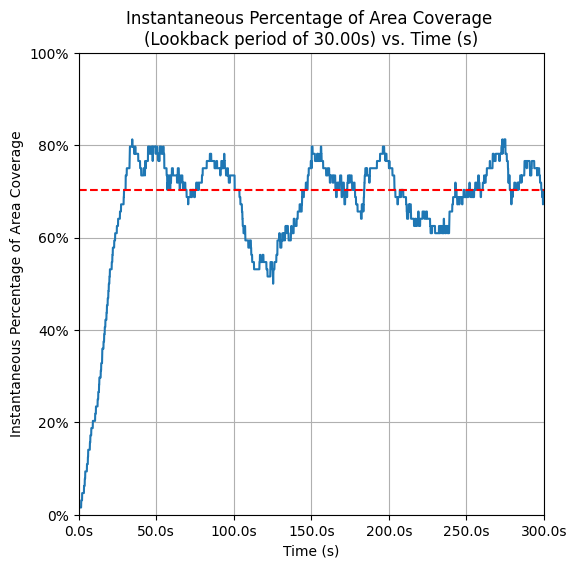

Visualizations complete! Returning metadata...
Result and parameters saved to  /Users/yasaridikut/WPI Classes/MQP Folder/milp-intro/src/mrpcp_2015/cache/mrpcp-standalone/8_8_3.0_1.5_3_m/graphs/intermediate_solutions/4/result.json
Result and parameters saved to  /Users/yasaridikut/WPI Classes/MQP Folder/milp-intro/src/mrpcp_2015/cache/mrpcp-standalone/8_8_3.0_1.5_3_m/graphs/intermediate_solutions/4/stats.json
H    0     0                      24.0031800    8.99871  62.5%     -   68s
     0     0    8.99871    0 1742   24.00318    8.99871  62.5%     -   68s

Cutting planes:
  Cover: 1
  Implied bound: 213
  Clique: 92
  MIR: 66
  Flow cover: 21
  Zero half: 4
  Network: 13

Explored 1 nodes (86512 simplex iterations) in 100.02 seconds (192.18 work units)
Thread count was 14 (of 14 available processors)

Solution count 5: 24.0032 39.5428 40.3246 ... 166.287

Time limit reached
Best objective 2.400318001813e+01, best bound 8.998712871598e+00, gap 62.5103%

User-callback calls 10333, time i

In [11]:
m._x = x
solver = MILPSolver(m)  # Create an instance of your MILP solver with multi-threading
solver.solve()  # Optimize until the first optimal solution is found or time limit is reached
optimized_node_paths, optimized_world_paths = solver.opt_node_paths, solver.opt_world_paths

Finished running MILP, running the visualization pipeline on the best result...
Running visualization pipeline...
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 61.99it/s]


	Visualizing visitation heatmap...
	Visualizing coverage over time...


100%|██████████| 3001/3001 [00:00<00:00, 6729.74it/s]


average_coverage=70.18783090821577


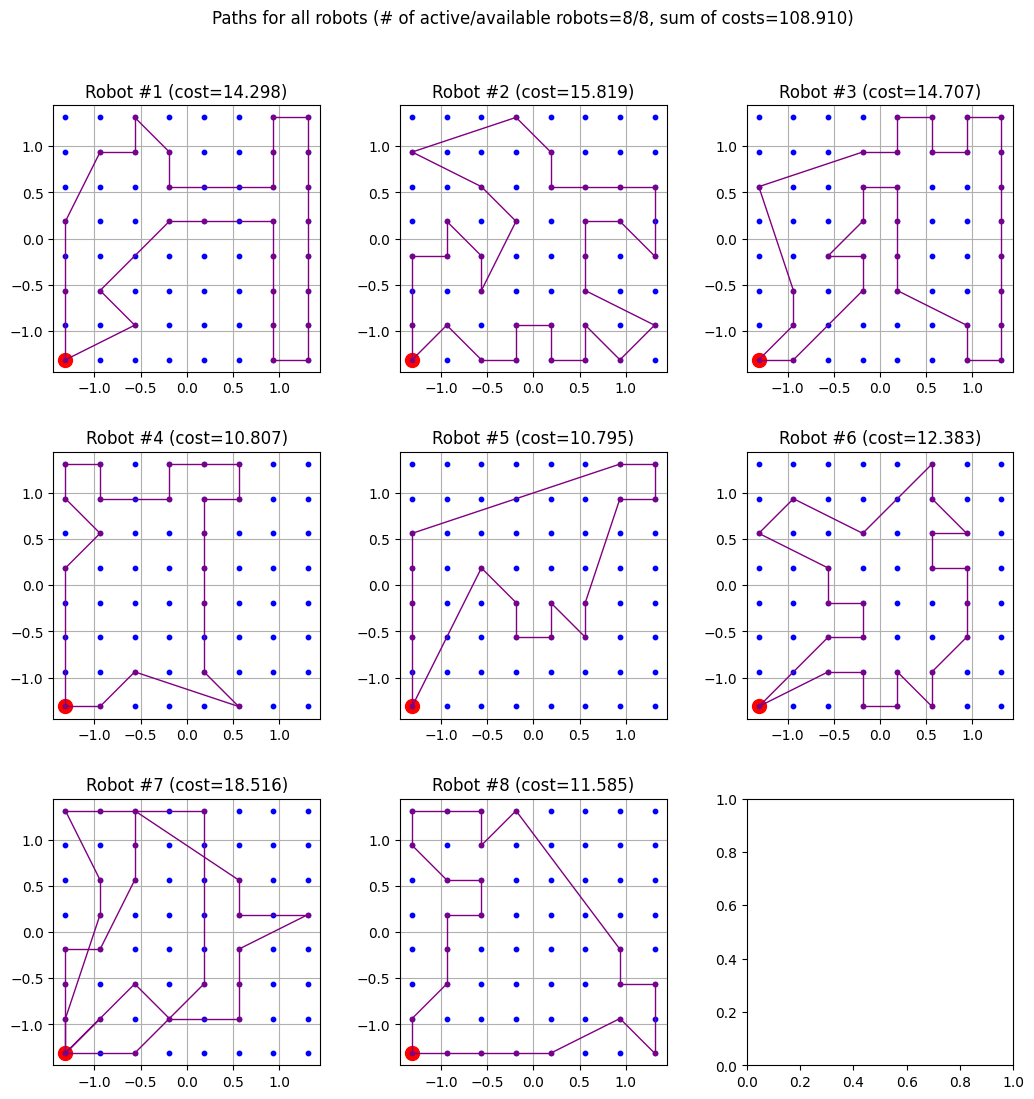

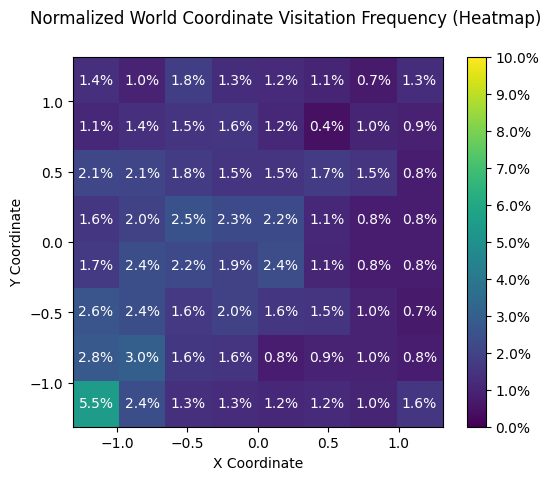

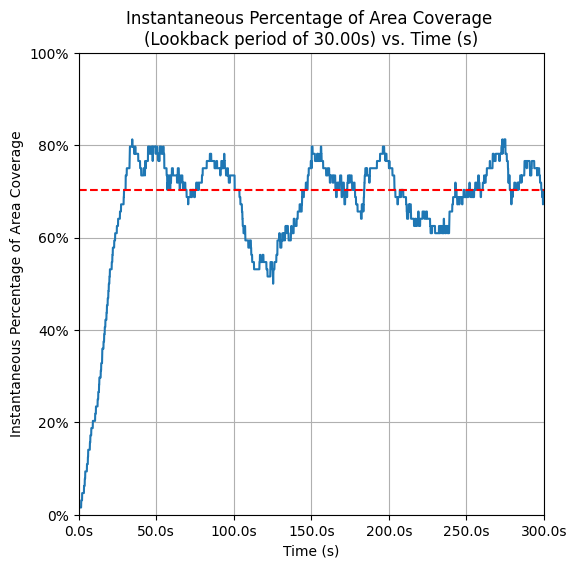

Visualizations complete! Returning metadata...
Result and parameters saved to  result.json
Result and parameters saved to  stats.json


<Figure size 640x480 with 0 Axes>

In [12]:
print("Finished running MILP, running the visualization pipeline on the best result...")
metadata = run_visualization_pipeline(optimized_node_paths, optimized_world_paths, metadata)

# Save result in a JSON file within the cache folder
result_data = {'job_id': metadata["job_id"],
               'params': {'k': k, 'n_a': n, 'ssd': ssd, 'fcr': fcr, 'rp': rp, 'mode': 'm'},
               'robot_node_path': optimized_node_paths, 'robot_world_path': optimized_world_paths,
               'status': 'completed'}
stats_data = {'job_id': metadata["job_id"], 'runtime': time.time() - milp_start_time,
              'average_coverage': metadata['average_coverage']}
metadata["saveResultsToCache"](metadata["job_id"], result_data, "result.json")  # Save the results to the cache
metadata["saveResultsToCache"](metadata["job_id"], stats_data, "stats.json")